# ANALYSE

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway

In [23]:
df = pd.read_csv("../data/CustomersNettoyé.csv")

## Test de Chi2 et Matrice de corrélation


=== Test Chi² pour les variables catégorielles ===
                                  Feature        Chi2        P-value  \
8             InternetService_Fiber optic  666.808021  4.940476e-147   
23                      Contract_Two year  641.828115  1.337680e-141   
25         PaymentMethod_Electronic check  640.557084  2.528030e-141   
14   DeviceProtection_No internet service  364.519799   2.920300e-81   
16        TechSupport_No internet service  364.519799   2.920300e-81   
20    StreamingMovies_No internet service  364.519799   2.920300e-81   
18        StreamingTV_No internet service  364.519799   2.920300e-81   
9                      InternetService_No  364.519799   2.920300e-81   
12       OnlineBackup_No internet service  364.519799   2.920300e-81   
10     OnlineSecurity_No internet service  364.519799   2.920300e-81   
3                        PaperlessBilling  258.277649   4.073355e-58   
22                      Contract_One year  221.710212   3.831327e-50   
11           

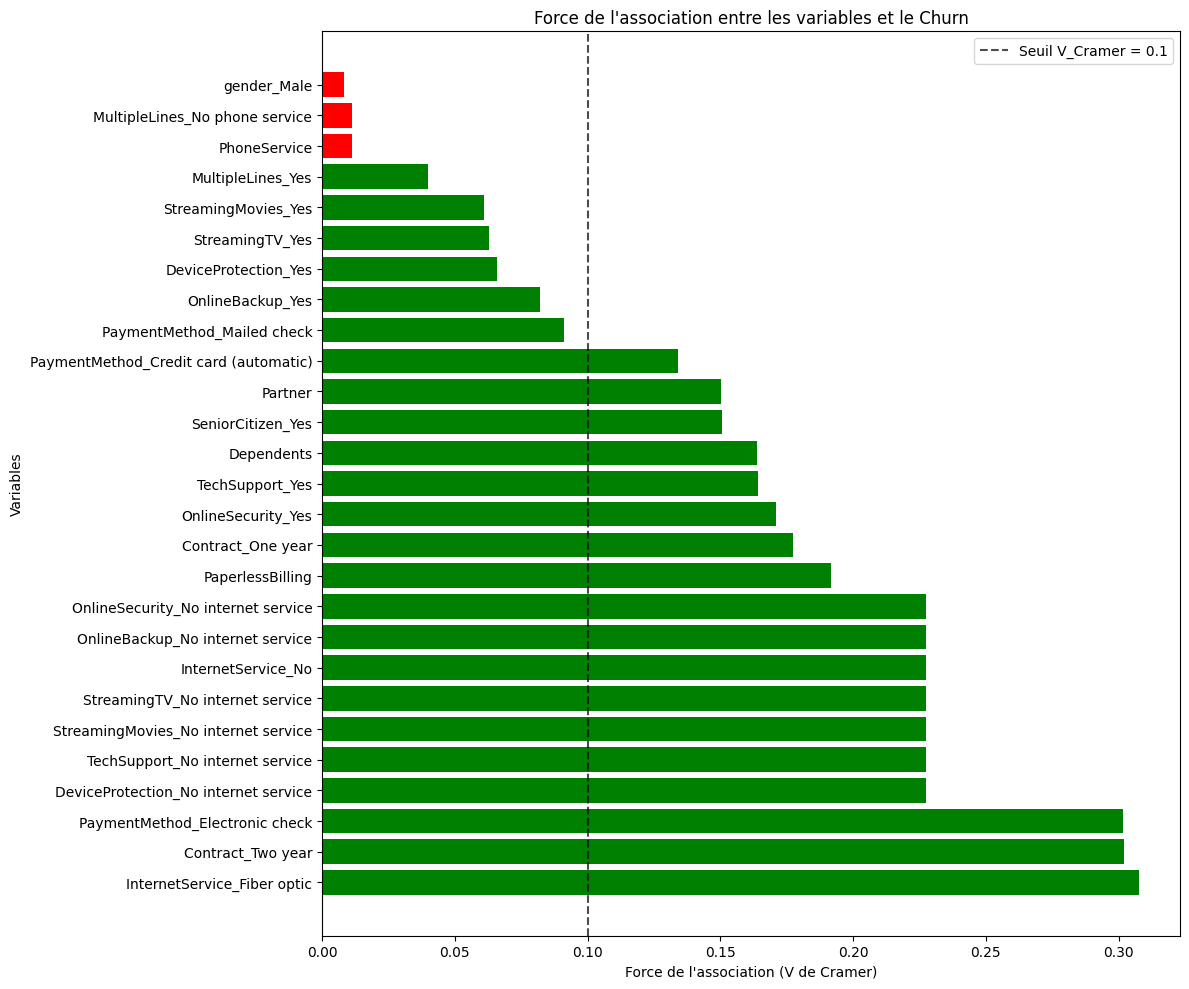

In [24]:
# Convertir les booléens en int si nécessaire
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

# Séparer les variables numériques et catégorielles
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in df.columns if col not in numeric_features + ['customerID', 'Churn']]

# Fonction simplifiée pour le test chi²
def simple_chi2_test(df, feature, target='Churn'):
    contingency = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Calculer V de Cramer (force de l'association)
    n = contingency.sum().sum()
    phi2 = chi2/n
    r, k = contingency.shape
    phi = np.sqrt(phi2 / min(k-1, r-1)) if min(k-1, r-1) > 0 else 0
    
    return feature, chi2, p, phi

# Fonction simplifiée pour le test ANOVA
def simple_anova_test(df, feature, target='Churn'):
    groups = []
    for val in df[target].unique():
        groups.append(df[df[target] == val][feature].dropna())
    
    f_stat, p_val = f_oneway(*groups)
    
    # Calculer eta² (équivalent du V de Cramer pour ANOVA)
    ss_between = sum(len(g) * ((g.mean() - df[feature].mean()) ** 2) for g in groups)
    ss_total = sum((df[feature] - df[feature].mean()) ** 2)
    eta2 = ss_between / ss_total if ss_total > 0 else 0
    
    return feature, f_stat, p_val, eta2

# Exécuter les tests
chi2_results = []
for feature in categorical_features:
    chi2_results.append(simple_chi2_test(df, feature))

anova_results = []
for feature in numeric_features:
    anova_results.append(simple_anova_test(df, feature))

# Créer des dataframes pour les résultats
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'P-value', 'V_Cramer'])
chi2_df['Significant'] = chi2_df['P-value'] < 0.05
chi2_df = chi2_df.sort_values('V_Cramer', ascending=False)

anova_df = pd.DataFrame(anova_results, columns=['Feature', 'F-stat', 'P-value', 'Eta_squared'])
anova_df['Significant'] = anova_df['P-value'] < 0.05
anova_df = anova_df.sort_values('Eta_squared', ascending=False)

# Afficher les résultats
print("=== Test Chi² pour les variables catégorielles ===")
print(chi2_df)

print("\n=== Test ANOVA pour les variables numériques ===")
print(anova_df)

# Identifier les variables peu utiles
print("\n=== Variables catégorielles peu utiles (V_Cramer < 0.1) ===")
weak_cat = chi2_df[chi2_df['V_Cramer'] < 0.1]
print(weak_cat[['Feature', 'V_Cramer', 'P-value']])

print("\n=== Variables numériques peu utiles (Eta_squared < 0.05) ===")
weak_num = anova_df[anova_df['Eta_squared'] < 0.05]
print(weak_num[['Feature', 'Eta_squared', 'P-value']])

# Liste finale des features à éliminer
features_to_drop = list(weak_cat['Feature']) + list(weak_num['Feature'])

print("\n=== Features à éliminer ===")
for feature in features_to_drop:
    print(f"- {feature}")

# Créer un dataframe sans les features inutiles
df_clean = df.drop(columns=features_to_drop)
print(f"\nDimensions avant: {df.shape}")
print(f"Dimensions après: {df_clean.shape}")


# Visualisation simple des résultats
plt.figure(figsize=(12, 10))
plt.barh(chi2_df['Feature'], chi2_df['V_Cramer'], color=['green' if x else 'red' for x in chi2_df['Significant']])
plt.axvline(x=0.1, color='black', linestyle='--', alpha=0.7, label='Seuil V_Cramer = 0.1')
plt.xlabel('Force de l\'association (V de Cramer)')
plt.ylabel('Variables')
plt.title('Force de l\'association entre les variables et le Churn')
plt.legend()
plt.tight_layout()
plt.savefig('chi2_results.png')
plt.show()




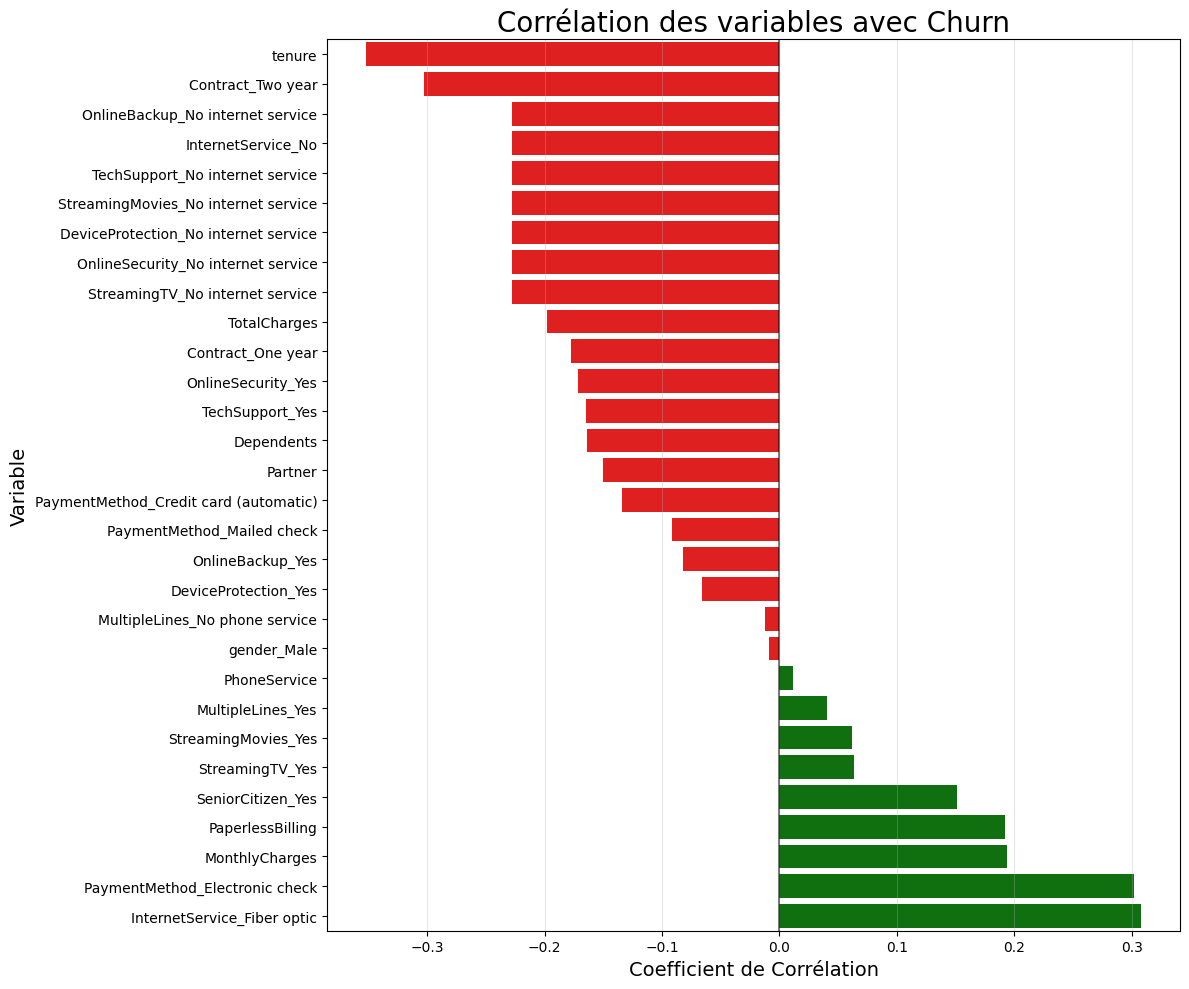

In [25]:
features_to_drop = [
    # Features avec très faible corrélation avec Churn
    'gender_Male',                   
    'PhoneService',                   
    'MultipleLines_No phone service', 
    
    # Variables catégorielles avec faible association
    'MultipleLines_Yes',              # V_Cramer = 0.039, très faible
    'StreamingMovies_Yes',            # V_Cramer = 0.061, faible
    'StreamingTV_Yes',                # V_Cramer = 0.062, faible
    'DeviceProtection_Yes',           # V_Cramer = 0.065, faible
    'OnlineBackup_Yes',               # V_Cramer = 0.081, faible
    'PaymentMethod_Mailed check', 
     
    # Charges totales (redondant avec MonthlyCharges)
    'TotalCharges',                   
    
    # Variables "No internet service" redondantes (garder seulement une)
    'OnlineBackup_No internet service', 
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]



In [26]:
df = df.drop(columns=features_to_drop)

In [27]:
df.head()

,customerID,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,Churn,SeniorCitizen_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,7590-VHVEG,1,0,1,1,29.85,0,0,0,0,0,0,0,0,0,0,1
1,5575-GNVDE,0,0,34,0,56.95,0,0,0,0,0,1,0,1,0,0,0
2,3668-QPYBK,0,0,2,1,53.85,1,0,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,0,0,45,0,42.30,0,0,0,0,0,1,1,1,0,0,0
4,9237-HQITU,0,0,2,1,70.70,1,0,1,0,0,0,0,0,0,0,1


In [28]:
df.dtypes

customerID                                object
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
SeniorCitizen_Yes                          int64
InternetService_Fiber optic                int64
InternetService_No                         int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
TechSupport_Yes                            int64
Contract_One year                          int64
Contract_Two year                          int64
PaymentMethod_Credit card (automatic)      int64
PaymentMethod_Electronic check             int64
dtype: object

In [29]:
df.to_csv("../data/CustomersFinal.csv", index=False)